imports

In [2]:
import json
import matplotlib.pyplot as plt
import tensorflow as tf

loading the dataset

In [3]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

hyperparameters

In [4]:
TRAINING_SIZE = 20000

VOCAB_SIZE = 10000

MAX_LENGTH = 32

PADDING_TYPE = 'pre'

TRUNC_TYPE = 'post'

splitting the dataset

In [5]:
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

data pre-processing

In [6]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

vectorize_layer.adapt(train_sentences)

I0000 00:00:1755287963.025269   45772 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))

In [8]:
def preprocessing_fn(dataset):

  dataset_sequences = dataset.map(lambda review, label: (vectorize_layer(review), label))

  dataset_sequences = dataset_sequences.ragged_batch(batch_size=dataset_sequences.cardinality())

  sequences, labels = dataset_sequences.get_single_element()

  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), maxlen=MAX_LENGTH, truncating=TRUNC_TYPE, padding=PADDING_TYPE)

  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)

  dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

  return dataset_vectorized

In [9]:
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

sanity check

In [10]:
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  319,    1,
        943, 4079, 2366,   47,  366,   94, 2026,    6, 2653, 9470],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    4, 7185, 3128, 3305,
         28,    2,  152,    1,  358, 2902,    6,  236,    9,  844],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



2025-08-16 01:30:21.027753: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


batching and optimizing

In [11]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

plot function

In [12]:
def plot_loss_acc(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

build and compile the model

In [13]:
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_conv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 28, 128)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

training the model

In [14]:
NUM_EPOCHS = 10

history_conv = model_conv.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10


I0000 00:00:1755288108.270275   45987 service.cc:152] XLA service 0x7f0220010600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755288108.270290   45987 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-16 01:31:48.289009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755288108.424847   45987 cuda_dnn.cc:529] Loaded cuDNN version 91002


130/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5777 - loss: 0.6751

I0000 00:00:1755288109.622438   45987 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6963 - loss: 0.5512 - val_accuracy: 0.8481 - val_loss: 0.3455
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8901 - loss: 0.2624 - val_accuracy: 0.8486 - val_loss: 0.3880
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9452 - loss: 0.1514 - val_accuracy: 0.8416 - val_loss: 0.4981
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9795 - loss: 0.0718 - val_accuracy: 0.8448 - val_loss: 0.6023
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9943 - loss: 0.0270 - val_accuracy: 0.8427 - val_loss: 0.7179
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9979 - loss: 0.0121 - val_accuracy: 0.8408 - val_loss: 0.7573
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9989 - loss: 0.0071 - val_accuracy: 0.8396 - val_loss: 0.8280
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.8390 - val_

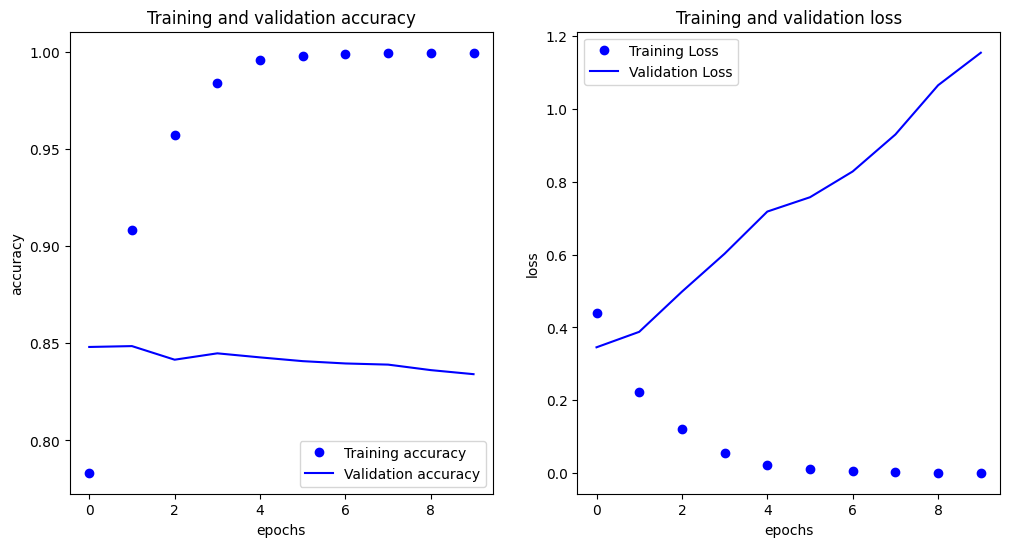

In [15]:
plot_loss_acc(history_conv)

overfitting aint goin anywhere